In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub
import os
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

csv = os.path.join(path, 'Reviews.csv')
df = pd.read_csv(csv)

In [3]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df_clean = df[['Text', 'Score']].dropna()

In [5]:
df_clean.head(5)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [6]:
df_binary = df_clean[df_clean['Score'] != 3].copy()
df_binary['sentiment'] = (df_binary['Score'] >= 4).astype(int)

In [7]:
df_binary.head(5)

,Text,Score,sentiment
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


In [8]:
from sklearn.utils import resample


negative_reviews = df_binary[df_binary['sentiment'] == 0]
positive_reviews = df_binary[df_binary['sentiment'] == 1]

print(f"Original imbalance:")
print(f"Negative: {len(negative_reviews):,} ({len(negative_reviews)/len(df_binary)*100:.1f}%)")
print(f"Positive: {len(positive_reviews):,} ({len(positive_reviews)/len(df_binary)*100:.1f}%)")
n_minority = len(negative_reviews)
positive_downsampled = resample(positive_reviews, replace=False, n_samples=n_minority, random_state=42)

df_balanced = pd.concat([negative_reviews, positive_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Original imbalance:
Negative: 82,037 (15.6%)
Positive: 443,777 (84.4%)


In [9]:
df_balanced.head(3)

,Text,Score,sentiment
0,"First of all, let me say that my dog likes the...",2,0
1,"I had really high hopes for this coffee, it sm...",1,0
2,I have tried all the varieties of Special K ce...,1,0


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

df_balanced['clean_text'] = df_balanced['Text'].apply(clean_text)

In [11]:
df_balanced.head(5)

,Text,Score,sentiment,clean_text
0,"First of all, let me say that my dog likes the...",2,0,first of all let me say that my dog likes the ...
1,"I had really high hopes for this coffee, it sm...",1,0,i had really high hopes for this coffee it sme...
2,I have tried all the varieties of Special K ce...,1,0,i have tried all the varieties of special k ce...
3,I placed an order for Dogswell Happy Hips for ...,1,0,i placed an order for dogswell happy hips for ...
4,"I usually dont like black herbal tea, but this...",5,1,i usually dont like black herbal tea but this ...


In [12]:
MAX_FEATURES = 10000
MAX_LEN = 100
X = df_balanced['clean_text'].values
y = df_balanced['sentiment'].values

#Out Of Vocab
tokenizer = Tokenizer(num_words=MAX_FEATURES , oov_token='<OOV>')
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)

#padding
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post', truncating='post')


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.20, random_state=42,stratify=y)

In [14]:
model = Sequential([
    Embedding(input_dim=MAX_FEATURES, output_dim=128, input_length=MAX_LEN),
    SimpleRNN(units=64, return_sequences=False),
    Dropout(0.3), #regula
    Dense(32, activation='relu'),
    Dense(16,activation='relu'),
    Dense(1, activation='sigmoid')])


In [15]:
rnn_model = model

In [16]:
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [17]:
rnn_history = rnn_model.fit(
    X_train, y_train,
    batch_size=128,
    epochs = 30,
    validation_split=0.20,
)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5175 - loss: 0.6926 - val_accuracy: 0.5225 - val_loss: 0.6914
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5313 - loss: 0.6856 - val_accuracy: 0.5765 - val_loss: 0.6578
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5850 - loss: 0.6358 - val_accuracy: 0.5706 - val_loss: 0.6598
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6129 - loss: 0.5938 - val_accuracy: 0.5868 - val_loss: 0.6474
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6332 - loss: 0.5777 - val_accuracy: 0.5556 - val_loss: 0.7012
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6179 - loss: 0.5767 - val_accuracy: 0.5850 - val_loss: 0.6726
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6293 - loss: 0.5460 - val_accuracy: 0.5808 - val_loss: 0.7445
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6276 - loss: 0.5531 - val

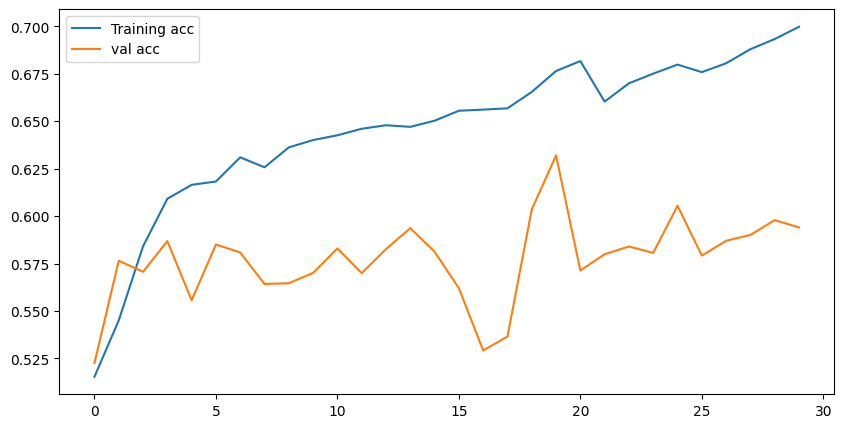

In [18]:
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'],label='Training acc')
plt.plot(rnn_history.history['val_accuracy'],label='val acc')
plt.legend()

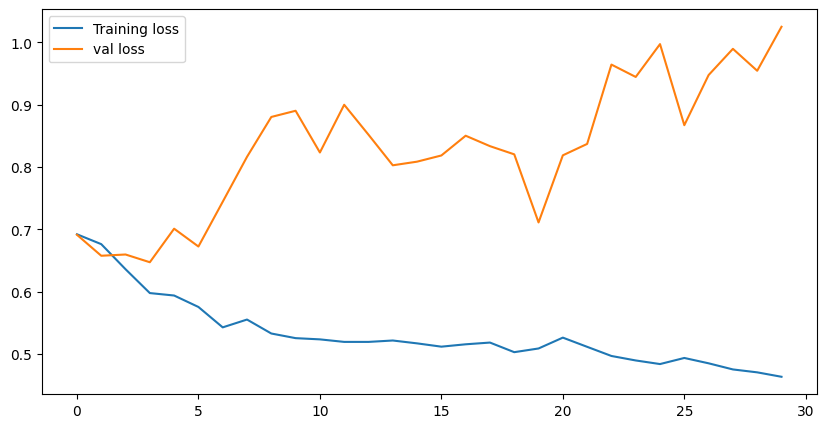

In [19]:
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'],label='Training loss')
plt.plot(rnn_history.history['val_loss'],label='val loss')
plt.legend()

In [20]:
Lstm_model = Sequential([
      Embedding(input_dim=MAX_FEATURES, output_dim=128, input_length=MAX_LEN),
      LSTM(units=128, return_sequences=False),
      Dropout(0.6), #regula
      Dense(32, activation='relu'),
      Dense(8, activation='relu'),
      Dense(1, activation='sigmoid')
])

In [21]:
Lstm_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [23]:
lstm_history = Lstm_model.fit(
    X_train, y_train,
    batch_size=128,
    epochs = 10,
    validation_split=0.20,
)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5532 - loss: 0.6793 - val_accuracy: 0.5038 - val_loss: 0.6999
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6595 - loss: 0.5852 - val_accuracy: 0.8815 - val_loss: 0.2912
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8971 - loss: 0.2636 - val_accuracy: 0.8633 - val_loss: 0.3017
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9196 - loss: 0.2030 - val_accuracy: 0.9098 - val_loss: 0.2300
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9447 - loss: 0.1549 - val_accuracy: 0.9155 - val_loss: 0.2312
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9569 - loss: 0.1262 - val_accuracy: 0.9190 - val_loss: 0.2287
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9692 - loss: 0.0971 - val_accuracy: 0.9190 - val_loss: 0.2608
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9754 - loss: 0.0815 - 

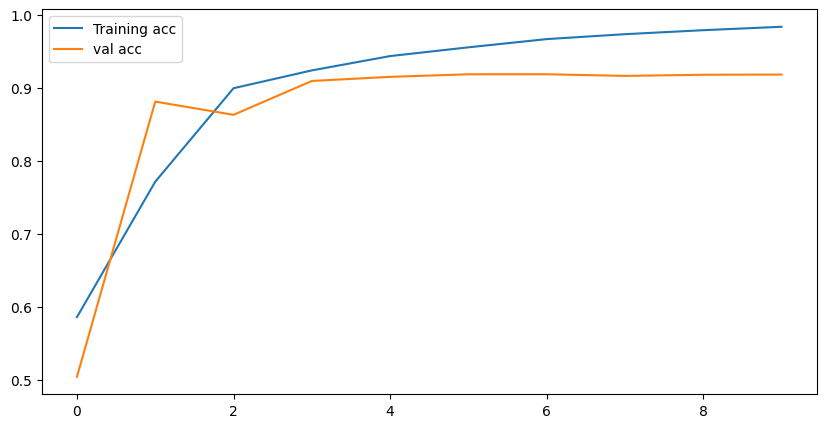

In [24]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history['accuracy'],label='Training acc')
plt.plot(lstm_history.history['val_accuracy'],label='val acc')
plt.legend()

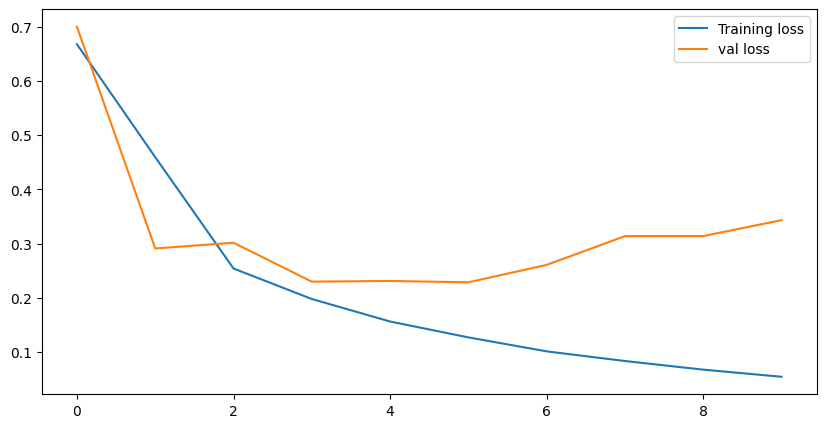

In [25]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history['loss'],label='Training loss')
plt.plot(lstm_history.history['val_loss'],label='val loss')
plt.legend()